In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings

# load pickle files for the checkerboard triangulation

## find the rotation and transit matrix for two pairs of camera

In [22]:
# load pickle files from camera 3d checkerboard triangulation
camera12_analyzed_path = "/home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_middle_camera_new_pos3_camera12-weikang-2022-09-20-3d/"
camera23_analyzed_path = "/home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_middle_camera_new_pos3_camera23-weikang-2022-09-20-3d/"
camera13_analyzed_path = "/home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_middle_camera_new_pos3_camera13-weikang-2022-09-20-3d/"

# load config.yaml file
camera12_config_path = camera12_analyzed_path + "config.yaml"
camera23_config_path = camera23_analyzed_path + "config.yaml"
camera13_config_path = camera13_analyzed_path + "config.yaml"

# load camera pair 1 and 2
camera12_stereo_pickle = camera12_analyzed_path + "camera_matrix/stereo_params.pickle"
camera12_camera1_params_pickle = camera12_analyzed_path + "camera_matrix/camera-1_intrinsic_params.pickle"
camera12_camera2_params_pickle = camera12_analyzed_path + "camera_matrix/camera-2_intrinsic_params.pickle"
camera12_checkerboard_trianglate_pickle = camera12_analyzed_path + "camera_matrix/triangulate.pickle"
camera12_stereo_params = pd.read_pickle(camera12_stereo_pickle)
camera12_camera1_params = pd.read_pickle(camera12_camera1_params_pickle)
camera12_camera2_params = pd.read_pickle(camera12_camera2_params_pickle)
camera12_checkerboard_trianglate = pd.read_pickle(camera12_checkerboard_trianglate_pickle)

# load camera pair 1 and 3
camera13_stereo_pickle = camera13_analyzed_path + "camera_matrix/stereo_params.pickle"
camera13_camera1_params_pickle = camera13_analyzed_path + "camera_matrix/camera-1_intrinsic_params.pickle"
camera13_camera3_params_pickle = camera13_analyzed_path + "camera_matrix/camera-3_intrinsic_params.pickle"
camera13_checkerboard_trianglate_pickle = camera13_analyzed_path + "camera_matrix/triangulate.pickle"
camera13_stereo_params = pd.read_pickle(camera13_stereo_pickle)
camera13_camera1_params = pd.read_pickle(camera13_camera1_params_pickle)
camera13_camera3_params = pd.read_pickle(camera13_camera3_params_pickle)
camera13_checkerboard_trianglate = pd.read_pickle(camera13_checkerboard_trianglate_pickle)

# load camera pair 2 and 3
camera23_stereo_pickle = camera23_analyzed_path + "camera_matrix/stereo_params.pickle"
camera23_camera2_params_pickle = camera23_analyzed_path + "camera_matrix/camera-2_intrinsic_params.pickle"
camera23_camera3_params_pickle = camera23_analyzed_path + "camera_matrix/camera-3_intrinsic_params.pickle"
camera23_checkerboard_trianglate_pickle = camera23_analyzed_path + "camera_matrix/triangulate.pickle"
camera23_stereo_params = pd.read_pickle(camera23_stereo_pickle)
camera23_camera2_params = pd.read_pickle(camera23_camera2_params_pickle)
camera23_camera3_params = pd.read_pickle(camera23_camera3_params_pickle)
camera23_checkerboard_trianglate = pd.read_pickle(camera23_checkerboard_trianglate_pickle)

In [6]:
camera12_checkerboard_trianglate.shape

(100, 4, 48)

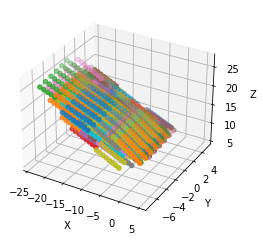

In [7]:
# sanity check
triangulate = camera12_checkerboard_trianglate
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(triangulate.shape[0]):
    xs = triangulate[i, 0, :]
    ys = triangulate[i, 1, :]
    zs = triangulate[i, 2, :]
    ax.scatter(xs, ys, zs)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

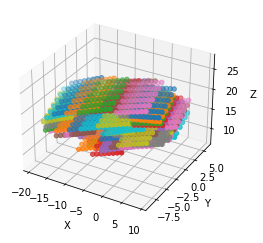

In [8]:
# sanity check
triangulate = camera23_checkerboard_trianglate
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(triangulate.shape[0]):
    xs = triangulate[i, 0, :]
    ys = triangulate[i, 1, :]
    zs = triangulate[i, 2, :]
    ax.scatter(xs, ys, zs)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [19]:
triangulate12 = camera12_checkerboard_trianglate
triangulate23 = camera23_checkerboard_trianglate
RR_sum = []
tt_sum = []
err_sum = []
RR_mean = np.zeros((3,3))
tt_mean = np.zeros((3,1))
n_mean = 0
if (triangulate12.shape[0] == triangulate23.shape[0]):
    for i in range(triangulate12.shape[0]):
        xs = triangulate12[i, 0, :]
        ys = triangulate12[i, 1, :]
        zs = triangulate12[i, 2, :]
        xxx_values = np.array([xs,ys,zs])
        xs = triangulate23[i, 0, :]
        ys = triangulate23[i, 1, :]
        zs = triangulate23[i, 2, :]
        yyy_values = np.array([xs,ys,zs])
        
        xxx_centroid = np.dot(np.mean(xxx_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        yyy_centroid = np.dot(np.mean(yyy_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        
        HH = np.dot((xxx_values - xxx_centroid), np.transpose(yyy_values - yyy_centroid))
        u, s, vh = np.linalg.svd(HH, full_matrices=True)
        RR = np.dot(np.transpose(vh),np.transpose(u))
        tt= yyy_centroid - np.dot(RR,xxx_centroid)
        tt = tt[:,1].reshape(3,1)
        
        err = np.sum(np.square(yyy_values - (np.dot(RR,xxx_values)+np.dot(tt, np.ones((1,np.shape(xxx_values)[1]))))))
        
        RR_sum.append(RR)
        tt_sum.append(tt)
        err_sum.append(err)
        
        # only consider low error
        if err < 2:
            RR_mean = RR_mean + RR
            tt_mean = tt_mean + tt
            n_mean = n_mean + 1

RR_mean = RR_mean/n_mean
tt_mean = tt_mean/n_mean
err_sum = np.array(err_sum)
RR_min = RR_sum[np.where(err_sum==np.min(err_sum))[0][0]]
tt_min = tt_sum[np.where(err_sum==np.min(err_sum))[0][0]]

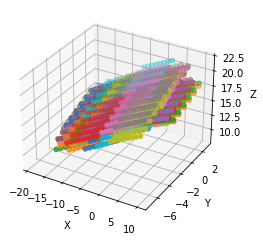

In [21]:
if (triangulate12.shape[0] == triangulate23.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    for i in range(triangulate12.shape[0]):
        xs = triangulate12[i, 0, :]
        ys = triangulate12[i, 1, :]
        zs = triangulate12[i, 2, :]
        xxx_values = np.array([xs,ys,zs])
        
        yyy_values_proj = np.transpose(np.dot(RR_mean,xxx_values) + np.dot(tt_mean, np.ones((1,np.shape(xxx_values)[1]))))
        
        xs = yyy_values_proj[:, 0]
        ys = yyy_values_proj[:, 1]
        zs = yyy_values_proj[:, 2]
        ax.scatter(xs, ys, zs)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        
RR_best = RR_mean
tt_best = tt_mean

# load video data and analyze

In [23]:
# 3d config.yaml file path
# camera12_config_path = "/home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_middle_camera_new_pos3_camera12-weikang-2022-09-20-3d/"

# 3d analyzed video path
camera12_video_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_3d/20220920_Dodson_Scorch_camera12/"
camera23_video_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_3d/20220920_Dodson_Scorch_camera23/"
camera13_video_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_3d/20220920_Dodson_Scorch_camera13/"

# h5 files for the analyzed videos
camera12_h5_file = camera12_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"
camera23_h5_file = camera23_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"
camera13_h5_file = camera13_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"

# h5 files for save 
camera12_h5_file_save = camera12_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"
camera23_h5_file_save = camera23_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"
camera13_h5_file_save = camera13_video_analyzed_path + "20220920_Dodson_Scorch_weikang.h5"

# meta pickle data for the analyzed videos
camera12_metapickle_file = camera12_video_analyzed_path + "20220920_Dodson_Scorch_weikang_meta.pickle"
camera23_metapickle_file = camera23_video_analyzed_path + "20220920_Dodson_Scorch_weikang_meta.pickle"
camera13_metapickle_file = camera13_video_analyzed_path + "20220920_Dodson_Scorch_weikang_meta.pickle"

# load data
camera12_metapickle_data = pd.read_pickle(camera12_metapickle_file)
camera23_metapickle_data = pd.read_pickle(camera23_metapickle_file)
camera13_metapickle_data = pd.read_pickle(camera13_metapickle_file)

camera12_h5_data = pd.read_hdf(camera12_h5_file)
camera23_h5_data = pd.read_hdf(camera23_h5_file)
camera13_h5_data = pd.read_hdf(camera13_h5_file)


In [24]:
# get the fps of the analyzed video
import cv2
video_cam1_file = camera12_video_analyzed_path + "20220920_Dodson_Scorch_camera-1.mp4"
cam = cv2.VideoCapture(video_cam1_file)
fps1 = cam.get(cv2.CAP_PROP_FPS)
video_cam2_file = camera12_video_analyzed_path + "20220920_Dodson_Scorch_camera-2.mp4"
cam = cv2.VideoCapture(video_cam2_file)
fps2 = cam.get(cv2.CAP_PROP_FPS)
fps = fps1
fps

29.97002997002997

## analyze based on camera 1 and 2

In [25]:
# analysis - camera 1 and 2
ncols = camera12_h5_data.shape[1]
nframes = camera12_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera12_h5_data.columns[i][1])
    body_parts.append(camera12_h5_data.columns[i][2])
    xyz_axis.append(camera12_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera12_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera12_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)
xyz_axis_unique = pd.unique(xyz_axis)
print(xyz_axis_unique)

# camera12_h5_data.to_hdf(camera12_h5_file_save, key = "camera12_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']
['x' 'y' 'z']


In [26]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera12_h5_data.iloc[:,ind]  
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera12 = body_part_locs

In [27]:
warnings.filterwarnings('ignore')
eye_direction_camera12 = {}
eye_contact_or_not_camera12 = {}
look_at_face_or_not_camera12 = {}
angle_thres = np.pi/36 # 5 degree
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera12[(iname)] = eye_dir_frames
    eye_contact_or_not_camera12[(iname)] = eye_contact_frames
    look_at_face_or_not_camera12[(iname)] = look_at_face_frames
        

In [28]:
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used
session_start_time = 33.03 # in second
session_start_frame = session_start_time * fps # fps is 30Hz

In [29]:
eye_direction_camera12['time_in_second'] = np.arange(0,np.shape(eye_direction_camera12['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera12['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera12['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera12['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera12['dodson'])[0],1)/30 - session_start_time

In [30]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['scorch'])==1)

(array([ 4583,  7021,  8981,  9904, 13982, 18033]),)

In [31]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['dodson'])==1)

(array([14362, 14363, 15389, 18033, 19389]),)

# analyze based on camera 2 and camera 3 

In [32]:
# analysis - camera 2 and 3
ncols = camera23_h5_data.shape[1]
nframes = camera23_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera23_h5_data.columns[i][1])
    body_parts.append(camera23_h5_data.columns[i][2])
    xyz_axis.append(camera23_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera23_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera23_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)

# camera23_h5_data.to_hdf(camera23_h5_file_save, key = "camera23_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']


In [33]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera23_h5_data.iloc[:,ind]    
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera23 = body_part_locs

In [34]:
warnings.filterwarnings('ignore')
eye_direction_camera23 = {}
eye_contact_or_not_camera23 = {}
look_at_face_or_not_camera23 = {}
angle_thres = np.pi/36 # 5 degree
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera23[(iname)] = eye_dir_frames
    eye_contact_or_not_camera23[(iname)] = eye_contact_frames
    look_at_face_or_not_camera23[(iname)] = look_at_face_frames
        

In [35]:
eye_direction_camera23['time_in_second'] = np.arange(0,np.shape(eye_direction_camera23['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera23['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera23['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera23['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera23['dodson'])[0],1)/30 - session_start_time

In [36]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['scorch'])==1)

(array([ 7339,  7340,  7341, 17003, 17004, 17005, 17006, 17007, 17430]),)

In [37]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['dodson'])==1)

(array([], dtype=int64),)

# examine the relationship between camera pairs
## make the 3d space aligned with each pair

In [41]:
# sanity check 
xxx = body_part_locs_camera12[('dodson','leftEye')].iloc[:,0]
yyy = body_part_locs_camera23[('dodson','leftEye')].iloc[:,0]

In [42]:
min_length = np.min([np.shape(xxx)[0],np.shape(yyy)[0]])
xxx = xxx[np.arange(0,min_length,1)]
yyy = yyy[np.arange(0,min_length,1)]

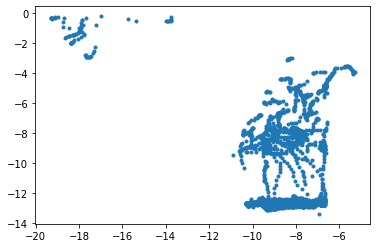

In [43]:
plt.plot(xxx,yyy,'.')

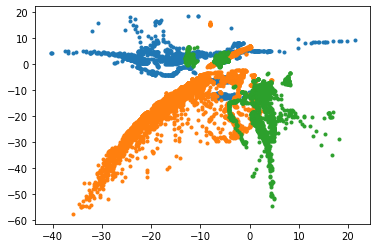

In [46]:
# use the best RR and tt identified above
# sanity check
xxx_plot = np.transpose(body_part_locs_camera12[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
yyy_plot = np.transpose(body_part_locs_camera23[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
tt_change = np.dot(tt_best, np.ones((1,np.shape(xxx_plot)[1])))
yyy_change = np.dot(RR_best,xxx_plot) + tt_change
plt.plot(xxx_plot[0,:],yyy_plot[0,:],'.')
plt.plot(xxx_plot[0,:],yyy_change[0,:],'.')
plt.plot(yyy_plot[0,:],yyy_change[0,:],'.')

## merge the bhv from the two pairs of camera and redo the analysis

In [47]:
# merge the two pairs of cameras
body_part_locs_merge = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        RR = RR_best
        tt = tt_best
        body_part_x = np.transpose(body_part_locs_camera12[(iname,ibody)].loc[np.arange(0,min_length,1),:])
        body_part_project = np.transpose(np.dot(RR,body_part_x) + np.dot(tt, np.ones((1,np.shape(body_part_x)[1]))))
        body_part_origin = body_part_locs_camera23[(iname,ibody)].loc[np.arange(0,min_length,1),:].values
        body_part_origin[np.sum(np.isnan(body_part_origin),axis=1)>0,:] = body_part_project[np.sum(np.isnan(body_part_origin),axis=1)>0,:]

        body_part_locs_merge[(iname,ibody)] = body_part_origin
        

In [48]:
warnings.filterwarnings('ignore')
eye_direction_merge = {}
eye_contact_or_not_merge = {}
look_at_face_or_not_merge = {}
angle_thres = np.pi/36 # 5 degree
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,min_length,1):
        lefteye_loc = body_part_locs_merge[(iname,'leftEye')][iframe,:]
        righteye_loc = body_part_locs_merge[(iname,'rightEye')][iframe,:]
        lefttuft_loc = body_part_locs_merge[(iname,'leftTuft')][iframe,:]
        righttuft_loc = body_part_locs_merge[(iname,'rightTuft')][iframe,:]
        whiblz_loc = body_part_locs_merge[(iname,'whiteBlaze')][iframe,:]
        mouth_loc = body_part_locs_merge[(iname,'mouth')][iframe,:]
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs_merge[(iname_other,'leftEye')][iframe,:]
        righteye_loc_other = body_part_locs_merge[(iname_other,'rightEye')][iframe,:]
        lefttuft_loc_other = body_part_locs_merge[(iname_other,'leftTuft')][iframe,:]
        righttuft_loc_other = body_part_locs_merge[(iname_other,'rightTuft')][iframe,:]
        whiblz_loc_other = body_part_locs_merge[(iname_other,'whiteBlaze')][iframe,:]
        mouth_loc_other = body_part_locs_merge[(iname_other,'mouth')][iframe,:]
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_merge[(iname)] = eye_dir_frames
    eye_contact_or_not_merge[(iname)] = eye_contact_frames
    look_at_face_or_not_merge[(iname)] = look_at_face_frames
        

In [49]:
eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/30 - session_start_time

## load behavioral results

In [50]:
# load behavioral results
bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/20220920_Dodson_Scorch/"
trial_record_json = bhv_data_path + "20220920_Scorch_Dodson_TrialRecord_1.json"
bhv_data_json = bhv_data_path + "20220920_Scorch_Dodson_bhv_data_1.json"
session_info_json = bhv_data_path + "20220920_Scorch_Dodson_session_info_1.json"

trial_record = pd.read_json(trial_record_json)
bhv_data = pd.read_json(bhv_data_json)
session_info = pd.read_json(session_info_json)

In [51]:
animal1 = session_info['lever1_animal'][0].lower()
animal2 = session_info['lever2_animal'][0].lower()

In [52]:
# clean up the trial_record
warnings.filterwarnings('ignore')
trial_record_clean = pd.DataFrame(columns=trial_record.columns)
for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
    # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
    trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
trial_record_clean = trial_record_clean.reset_index(drop = True)

In [53]:
# change bhv_data time to the absolute time
time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
    ind = bhv_data["trial_number"]==itrial+1
    new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
    time_points_new["time_points_new"][ind] = new_time_itrial
bhv_data["time_points"] = time_points_new["time_points_new"]

## plot behavioral results (with camera pair merged) and eye contact results

In [64]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_merge[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_merge[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_merge[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_merge[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact2]

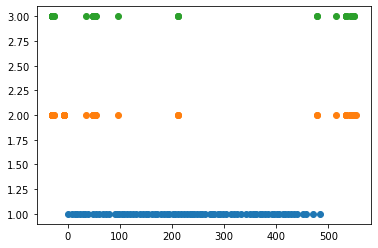

In [65]:
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface1, np.ones(np.shape(time_point_lookatotherface1)[0])*2,'o')
plt.plot(time_point_eyecontact1, np.ones(np.shape(time_point_eyecontact1)[0])*3,'o')

In [66]:
(time_point_eyecontact1+session_start_time)/60

array([0.04166667, 0.04222222, 0.04277778, 0.04333333, 0.045     ,
       0.04555556, 0.04611111, 0.04666667, 0.04722222, 0.04777778,
       0.04833333, 0.04888889, 0.04944444, 0.05      , 0.05055556,
       0.05111111, 0.05166667, 0.05222222, 0.05555556, 0.11333333,
       0.12111111, 1.12222222, 1.35055556, 1.37333333, 1.37388889,
       1.37444444, 1.375     , 1.37611111, 1.37666667, 1.37722222,
       1.37777778, 1.37833333, 1.37888889, 1.38611111, 1.41777778,
       1.41833333, 1.42      , 1.42055556, 1.42111111, 1.42166667,
       1.42222222, 1.42277778, 1.42333333, 1.42388889, 1.42444444,
       1.425     , 1.42555556, 1.42611111, 1.44055556, 2.14777778,
       4.07722222, 4.07777778, 4.07833333, 8.53444444, 8.53555556,
       9.14277778, 9.44611111, 9.44666667, 9.44722222, 9.44777778,
       9.44833333, 9.6       , 9.60833333, 9.60888889, 9.60944444,
       9.68333333, 9.69111111, 9.69277778])

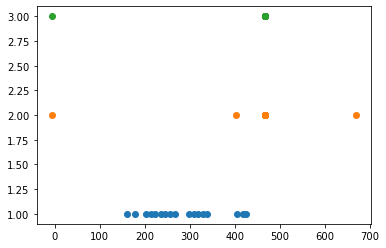

In [56]:
ind_plot = time_point_pull2 < 720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface2, np.ones(np.shape(time_point_lookatotherface2)[0])*2,'o')
plt.plot(time_point_eyecontact2, np.ones(np.shape(time_point_eyecontact2)[0])*3,'o')

## plot behavioral results (with camera 12) and eye contact results

In [57]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera12[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera12[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera12[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera12[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact2]

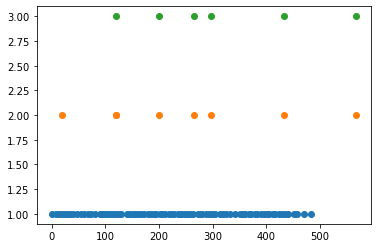

In [58]:
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface1, np.ones(np.shape(time_point_lookatotherface1)[0])*2,'o')
plt.plot(time_point_eyecontact1, np.ones(np.shape(time_point_eyecontact1)[0])*3,'o')

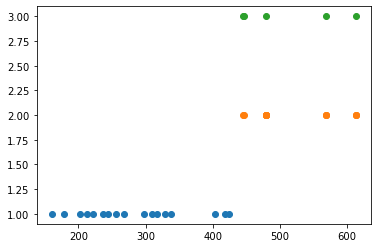

In [59]:
ind_plot = time_point_pull2 < 720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface2, np.ones(np.shape(time_point_lookatotherface2)[0])*2,'o')
plt.plot(time_point_eyecontact2, np.ones(np.shape(time_point_eyecontact2)[0])*3,'o')

## plot behavioral results (with camera 23) and eye contact results

In [60]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera23[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera23[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera23[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera23[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact2]

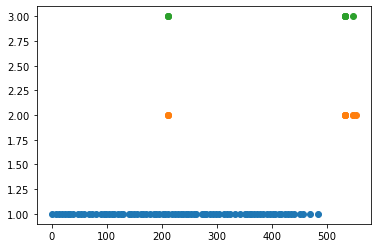

In [61]:
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface1, np.ones(np.shape(time_point_lookatotherface1)[0])*2,'o')
plt.plot(time_point_eyecontact1, np.ones(np.shape(time_point_eyecontact1)[0])*3,'o')

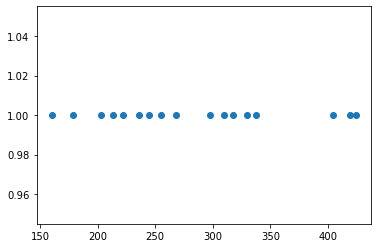

In [62]:
ind_plot = time_point_pull2 <720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(time_point_lookatotherface2, np.ones(np.shape(time_point_lookatotherface2)[0])*2,'o')
plt.plot(time_point_eyecontact2, np.ones(np.shape(time_point_eyecontact2)[0])*3,'o')